# ML Olympiad - Kaggle competition
**Objetivo**: Os competidores terão que criar modelos para predizer qual o agente causador da síndrome respiratória aguda grave com base nos dados e sintomas dos pacientes.

# Imports

In [ ]:
import struct

# Basics
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import plotly.express as px

# CatBoost
from catboost import CatBoostClassifier
from catboost import Pool

from sklearn.neighbors import KNeighborsClassifier

# Train test
from sklearn.model_selection import train_test_split

# Metrics
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score

# MLXtend - Apriori
import mlxtend.frequent_patterns
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import association_rules
# Model explaination
import shap

# Dataset Load

In [2]:
file_path = 'C:/Users/1770858/Desktop/ml-olympiad-ensure-healthy-lives/train.csv'
df = pd.read_csv(file_path)
# Remove mostly NAs
df.drop([964116, 1162729, 848580, 1108616, 434934, 286956], axis=0, inplace=True)
df= df.reset_index(drop=True)

to_drop = ((df == 9).sum(axis=1) / 76).to_frame().rename(columns={0: 'missing'}).reset_index()
to_drop = to_drop.query('missing > 0.4')['index'].to_list()
df.drop(to_drop, axis=0, inplace=True)
df= df.reset_index(drop=True)

Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.


In [64]:
# Data information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300645 entries, 0 to 1300644
Data columns (total 76 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   SEM_NOT     1300645 non-null  int64  
 1   SEM_PRI     1300645 non-null  int64  
 2   SG_UF_NOT   1300645 non-null  object 
 3   ID_REGIONA  1152995 non-null  object 
 4   CO_REGIONA  1152995 non-null  float64
 5   ID_MUNICIP  1300645 non-null  object 
 6   CO_MUN_NOT  1300645 non-null  int64  
 7   CS_SEXO     1300645 non-null  object 
 8   NU_IDADE_N  1300645 non-null  int64  
 9   TP_IDADE    1300645 non-null  int64  
 10  COD_IDADE   1300645 non-null  object 
 11  CS_GESTANT  1300645 non-null  int64  
 12  CS_RACA     1300645 non-null  int64  
 13  CS_ESCOL_N  845584 non-null   float64
 14  SG_UF       1300409 non-null  object 
 15  CS_ZONA     1165820 non-null  float64
 16  SURTO_SG    78730 non-null    float64
 17  NOSOCOMIAL  1099143 non-null  float64
 18  AVE_SUINO   1080730 no

In [65]:
# View data header
df.head()

,SEM_NOT,SEM_PRI,SG_UF_NOT,ID_REGIONA,CO_REGIONA,ID_MUNICIP,CO_MUN_NOT,CS_SEXO,NU_IDADE_N,TP_IDADE,...,PERD_PALA,TOMO_RES,TOMO_OUT,VACINA_COV,DOSE_1_COV,DOSE_2_COV,DOSE_REF,FNT_IN_COV,DELTA_UTI,ID
0,38,37,RS,005 CRS,1608.0,CAXIAS DO SUL,430510,M,73,3,...,NaN,NaN,NaN,2.0,0,0,0,1.0,-1,87360a9a-5516-4b0c-9c76-faceb759e97b
1,46,46,MS,NRS DE PONTA PORA,1972.0,PONTA PORA,500660,M,27,3,...,2.0,NaN,NaN,9.0,0,0,0,1.0,-1,e5532e89-f7e8-4239-991b-16cf3c3a5be6
2,18,17,CE,1 CRES FORTALEZA,1519.0,FORTALEZA,230440,F,2,3,...,2.0,6.0,NaN,1.0,1,1,0,2.0,-1,dbaa33c2-d374-48d7-a0f3-f0775550b1a4
3,4,3,SP,GVE VII SANTO ANDRE,1332.0,MAUA,352940,F,71,3,...,2.0,6.0,NaN,1.0,1,1,0,2.0,-1,ecbf8128-42a7-4668-be28-905b6168578d
4,12,11,MG,JANUARIA,1470.0,SAO JOAO DA PONTE,316240,F,91,3,...,2.0,NaN,NaN,2.0,0,0,0,1.0,-1,4b74f720-bd35-42b0-8590-127985c79653


# Exploratory Data Analysis
Let's explore the data and start looking at where the disease happens more, based on location, simptoms, etc.
Our goal with this project is to classify the type of the respiratory disease  `CLASSI_FIN` target variable.

#### **Target Variable Exploration**
Most of the cases are related to Covid. 66%, followed by 29% not specified.

In [84]:
# Let's have a look at our target variable
df.CLASSI_FIN.unique()

array([4, 5, 1, 2, 3])

There are 5 kinds of classification, being:
* *1 = "SRAG by Influenza"* 
* *2 = "SRAG by other respiratory virus"* 
* *3 = "SRAG by another agent"* 
* *4 = "SRAG not specified"* 
* *5 = SRAG from COVID*. 

But the data is very unbalanced, as we can see below.

In [66]:
# Map names to target variable
df['srag'] = df.CLASSI_FIN.map({1:'influenza', 2: 'othr virus', 3: 'othr agent', 4: 'not specif', 5: 'COVID'})

Disease final classification % :
COVID         0.667
not specif    0.292
othr virus    0.024
influenza     0.012
othr agent    0.005
Name: srag, dtype: float64

------



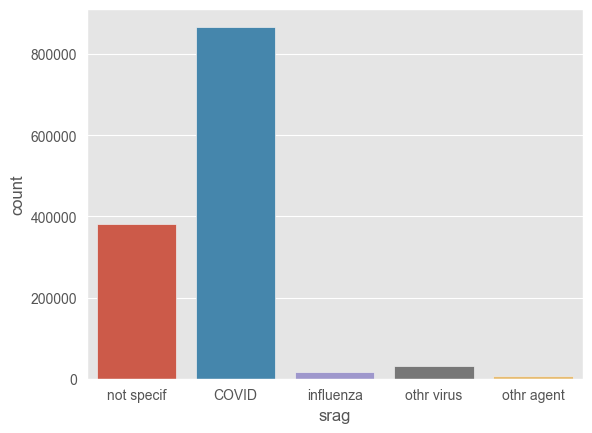

In [67]:
print('Disease final classification % :')
print(df.srag.value_counts(normalize=True, dropna=False).round(3))
print('\n------\n')

# Plot bars
sns.countplot(data= df,
              x= 'srag');

Next, we can see the top categories from each categorical variable. We're not list all the simptoms variables because those are mostly coded as 1=Yes, 2=No, 9=NA

In [68]:
# Stats descriptions of some variables
df.describe(include= 'object').T

,count,unique,top,freq
SG_UF_NOT,1300645,27,SP,381673
ID_REGIONA,1152995,311,GVE I CAPITAL,114650
ID_MUNICIP,1300645,2863,SAO PAULO,114650
CS_SEXO,1300645,3,M,697078
COD_IDADE,1300645,327,3001,22319
SG_UF,1300409,27,SP,379748
OUTRO_DES,396425,85045,CEFALEIA,33488
OBES_IMC,14093,473,30,1655
MORB_DESC,317295,78100,HAS,84588
RAIOX_OUT,46003,11260,SEM LAUDO,3165


#### **Does the UF influence the Final classification?**
Most of the states are reporting the RSV as related mainly to Covid (top reason). The only state that the largest group is different is PE, where the most classified reason is "4. Not specified"

In [ ]:
# Group by state of the notification and got the largest group.
( df
 .groupby('SG_UF_NOT')
 .CLASSI_FIN.value_counts()
 .groupby('SG_UF_NOT').nlargest(1)   
)

SG_UF_NOT  SG_UF_NOT  CLASSI_FIN
AC         AC         5               2012
AL         AL         5               9727
AM         AM         5              13165
AP         AP         5               2397
BA         BA         5              32962
CE         CE         5              30084
DF         DF         5              19187
ES         ES         5               5406
GO         GO         5              36224
MA         MA         5               9820
MG         MG         5              98530
MS         MS         5              15256
MT         MT         5              15655
PA         PA         5              19677
PB         PB         5              12423
PE         PE         4              16130
PI         PI         5               9068
PR         PR         5              67564
RJ         RJ         5              71402
RN         RN         5               8773
RO         RO         5               7095
RR         RR         5               1976
RS         RS        

#### **Where are we seeing more diseases notified?**
The cases are following the size of the population. The more the state is populated, the more cases are reported.

In [ ]:
# scrap population density from the web
dens_pop = pd.read_html('https://pt.wikipedia.org/wiki/Lista_de_unidades_federativas_do_Brasil_por_densidade_demogr%C3%A1fica')[1]

In [ ]:
dens_pop = dens_pop[['Unidade federativa', 'População (projeção 2019)', 'Densidade demográfica (projeção 2019)']].copy()
dens_pop.columns = ['estado', 'populacao', 'densidade']
dens_pop['SG_UF_NOT'] = str.split('DF, RJ, SP, AL, SE, PE, ES, SC, PB, RN, CE, PR, RS, MG, BA, MA, GO, PI, MS, RO, PA, AP, TO, AC, MT, RR, AM', sep=', ')
dens_pop['populacao'] = dens_pop.populacao.apply(lambda x: x.replace('.', '', 1) if len(x) > 7 else x)
dens_pop = dens_pop.astype({'populacao': 'float'})

In [ ]:
# Cases by state add population density
cases_by_state = df.groupby('SG_UF_NOT').CLASSI_FIN.count().reset_index().sort_values(by='CLASSI_FIN')
cases_by_state = cases_by_state.merge(dens_pop, on='SG_UF_NOT')

In [ ]:
cases_by_state['pct_pop_sick'] = cases_by_state.CLASSI_FIN/cases_by_state.populacao

In [ ]:
cases_by_state

,SG_UF_NOT,CLASSI_FIN,estado,populacao,densidade,pct_pop_sick
0,RR,2560,Roraima,605.761,270,4.226089
1,AP,3230,Amapá,845.731,594,3.819181
2,AC,3563,Acre,881.935,537,4.039980
3,TO,7693,Tocantins,1572.866,566,4.891071
4,RO,9131,Rondônia,1777.225,747,5.137785
5,ES,9724,Espírito Santo,4018.650,8722,2.419718
6,PI,11780,Piauí,3273.227,1301,3.598895
7,RN,12068,Rio Grande do Norte,3506.853,6641,3.441262
8,SE,13355,Sergipe,2298.696,10483,5.809816
9,MA,13658,Maranhão,7075.181,2146,1.930410


In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create the Subplots area with 2 rows and 2 columns (4 plots)
fig = make_subplots(rows=2, cols=2,
                    #Graph Types
                    specs=[ [{'type': 'xy'}, {'type': 'xy'}],
                            [{'type': 'xy'}, {'type': 'xy'}] ],
                            
                    # Titles for each graphic
                    subplot_titles=("| CASES by STATE", "| % Population Sick by State", 
                                    "| CASES by POPULATION", "| % Pop Sick by Densidade"    ))


# Title for the Dashboard
fig.update_layout(height=800, width=1400, title_text="VISUALIZATIONS : Cases by State")
fig.update_layout(showlegend=False)


# Plot 1 | Cases by state
fig.add_trace(go.Bar(x= cases_by_state['SG_UF_NOT'], y=cases_by_state['CLASSI_FIN'], name='(State, Cases)'),
              row=1, col=1)

# Plot 2 | Pct sick by state
fig.add_trace(go.Bar(x= cases_by_state['SG_UF_NOT'], y=cases_by_state['pct_pop_sick'], name='(State, %Cases)'),
              row=1, col=2)


# Plot 3 | Cases by Population
fig.add_trace(go.Scatter(x= cases_by_state['populacao'], y=cases_by_state['CLASSI_FIN'], 
                         mode='markers', marker=dict(size=10, opacity=.5),
                         name='(Pop, Cases)'),
              row=2, col=1)


# Plot 4 | Density by Pop Sick
fig.add_trace(go.Scatter(x= cases_by_state['densidade'], y=cases_by_state['pct_pop_sick'], 
                         mode='markers', marker=dict(size=10, opacity=.5),
                         name='(Pop, %Cases)'),
              row=2, col=2)

fig.show()

#### **Sex influence anything?**
The distributions are similar. The men are slightly more risked to report group 5 (COVID).

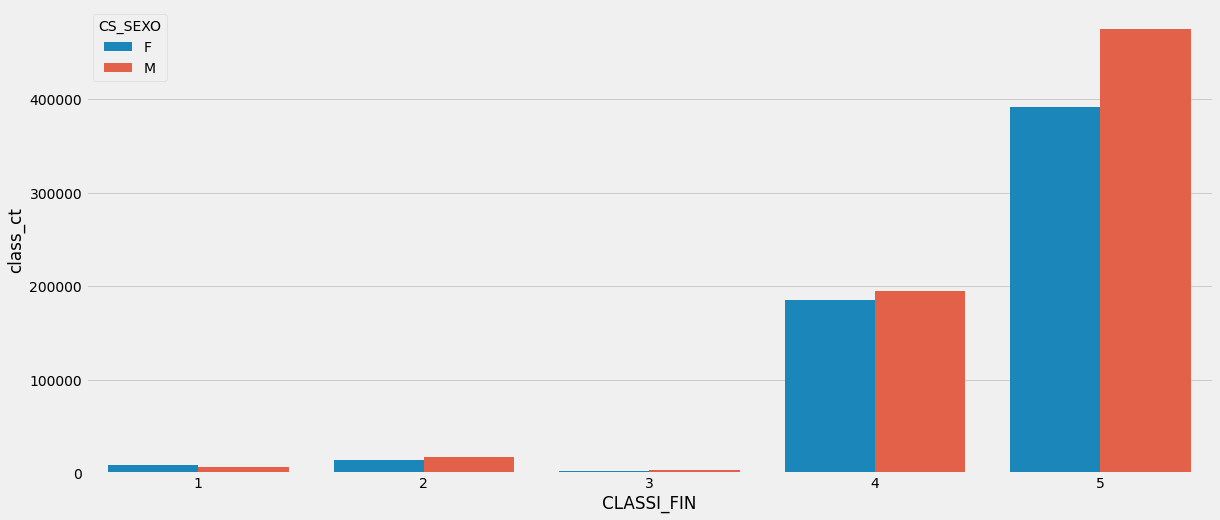

In [ ]:
class_by_sex = df.query('CS_SEXO != "I"').groupby('CS_SEXO').CLASSI_FIN.value_counts().to_frame().rename(columns={'CLASSI_FIN': 'class_ct'}).reset_index()
#Plot
plt.figure(figsize=(18,8))
sns.barplot(data=class_by_sex, x= 'CLASSI_FIN', y= 'class_ct', hue= 'CS_SEXO');

### Person used Influenza Antiviral?
97% of people affected with Influenza used it.

In [69]:
df.groupby('srag').TP_ANTIVIR.value_counts(normalize=True)

srag        TP_ANTIVIR
COVID       1.0           0.747471
            3.0           0.238913
            2.0           0.013616
influenza   1.0           0.974535
            3.0           0.020895
            2.0           0.004571
not specif  1.0           0.932063
            3.0           0.061015
            2.0           0.006922
othr agent  1.0           0.920455
            3.0           0.068182
            2.0           0.011364
othr virus  1.0           0.972477
            3.0           0.022211
            2.0           0.005311
Name: TP_ANTIVIR, dtype: float64

# Selecting the variables for the first model

In [63]:
# Select columns to keep
cols_to_keep = ['ID', 'CLASSI_FIN', 'SEM_NOT', 'SEM_PRI', 'SG_UF_NOT', 'CS_SEXO', 'NU_IDADE_N', 'TP_IDADE', 'NOSOCOMIAL', 'FEBRE', 'TOSSE', 'GARGANTA',
       'DISPNEIA', 'DESC_RESP', 'SATURACAO', 'DIARREIA', 'VOMITO', 'OUTRO_SIN', 'OUTRO_DES', 'PUERPERA', 'FATOR_RISC', 'CARDIOPATI', 'HEMATOLOGI',
       'SIND_DOWN', 'HEPATICA', 'ASMA', 'DIABETES', 'NEUROLOGIC', 'PNEUMOPATI', 'IMUNODEPRE', 'RENAL', 'OBESIDADE', 'OUT_MORBI', 'MORB_DESC',
       'VACINA', 'UTI', 'SUPORT_VEN', 'HISTO_VGM','DOR_ABD', 'FADIGA', 'PERD_OLFT', 'PERD_PALA', 'TOMO_RES', 'VACINA_COV','DOSE_2_COV', 'DOSE_REF']

# Slice dataset
df_model = df[cols_to_keep].copy()

In [64]:
# Correcting IDADE
# Tipo 1 = dia, tipo 2 = Mês, 3= Ano
df_model['NU_IDADE_N'] = np.select( [df_model.TP_IDADE == 1, df_model.TP_IDADE == 2, df_model.TP_IDADE == 3],
                                    [round(df_model.NU_IDADE_N/365), round(df_model.NU_IDADE_N/12), df_model.NU_IDADE_N] )
df_model.drop('TP_IDADE', axis=1, inplace=True)

In [65]:
df_model.shape

(1300980, 45)

In [66]:
cols_to_drop = ['ID', 'CLASSI_FIN', 'SEM_NOT', 'SEM_PRI', 'SG_UF_NOT', 'NU_IDADE_N', 'OUTRO_DES', 'MORB_DESC']
pd.DataFrame({
    'variable': df_model.drop(cols_to_drop, axis=1).columns,
    'unique values': df_model.drop(cols_to_drop, axis=1).nunique(),
    'values': [df[x].unique() for x in df_model.drop(cols_to_drop, axis=1).columns]
})

,variable,unique values,values
CS_SEXO,CS_SEXO,3,"[M, F, I]"
NOSOCOMIAL,NOSOCOMIAL,3,"[2.0, nan, 9.0, 1.0]"
FEBRE,FEBRE,3,"[nan, 1.0, 2.0, 9.0]"
TOSSE,TOSSE,3,"[nan, 1.0, 2.0, 9.0]"
GARGANTA,GARGANTA,3,"[nan, 1.0, 2.0, 9.0]"
DISPNEIA,DISPNEIA,3,"[nan, 2.0, 1.0, 9.0]"
DESC_RESP,DESC_RESP,3,"[nan, 2.0, 1.0, 9.0]"
SATURACAO,SATURACAO,3,"[nan, 2.0, 1.0, 9.0]"
DIARREIA,DIARREIA,3,"[nan, 2.0, 1.0, 9.0]"
VOMITO,VOMITO,3,"[nan, 2.0, 9.0, 1.0]"


# Missing Values

For an initial model since the missing values are marked as category #9, we will replace the NAs with 9 and run the model.

In [ ]:
# Checking for missing data
df_model.isnull().sum().sort_values(ascending=False).head(50)

In [67]:
# Replacing the NAs with 9
df_model = df_model.fillna('9')

# Check again for NAs
#df_model.isnull().sum().sort_values(ascending=False).head(50)

In [17]:
# Columns to Categories for modeling

num_col = ['NOSOCOMIAL', 'FEBRE', 'TOSSE', 'GARGANTA', 'CLASSI_FIN',
       'DISPNEIA', 'DESC_RESP', 'SATURACAO', 'DIARREIA', 'VOMITO', 'OUTRO_SIN', 'PUERPERA', 'FATOR_RISC', 'CARDIOPATI', 'HEMATOLOGI',
       'SIND_DOWN', 'HEPATICA', 'ASMA', 'DIABETES', 'NEUROLOGIC', 'PNEUMOPATI', 'IMUNODEPRE', 'RENAL', 'OBESIDADE', 'OUT_MORBI',
       'VACINA', 'UTI', 'SUPORT_VEN', 'HISTO_VGM','DOR_ABD', 'FADIGA', 'PERD_OLFT', 'PERD_PALA', 'TOMO_RES', 'VACINA_COV','DOSE_2_COV', 'DOSE_REF']

col_types = ['SG_UF_NOT', 'CS_SEXO','NOSOCOMIAL', 'FEBRE', 'TOSSE', 'GARGANTA', 'OUTRO_DES', 'MORB_DESC', 'CLASSI_FIN',
       'DISPNEIA', 'DESC_RESP', 'SATURACAO', 'DIARREIA', 'VOMITO', 'OUTRO_SIN', 'PUERPERA', 'FATOR_RISC', 'CARDIOPATI', 'HEMATOLOGI',
       'SIND_DOWN', 'HEPATICA', 'ASMA', 'DIABETES', 'NEUROLOGIC', 'PNEUMOPATI', 'IMUNODEPRE', 'RENAL', 'OBESIDADE', 'OUT_MORBI',
       'VACINA', 'UTI', 'SUPORT_VEN', 'HISTO_VGM','DOR_ABD', 'FADIGA', 'PERD_OLFT', 'PERD_PALA', 'TOMO_RES', 'VACINA_COV','DOSE_2_COV', 'DOSE_REF']

# Assign as categorical
df_model[num_col] = df_model[num_col].astype('int')
df_model[col_types] = df_model[col_types].astype('category')
df_model.dtypes

ID              object
CLASSI_FIN    category
SEM_NOT          int64
SEM_PRI          int64
SG_UF_NOT     category
CS_SEXO       category
NU_IDADE_N     float64
NOSOCOMIAL    category
FEBRE         category
TOSSE         category
GARGANTA      category
DISPNEIA      category
DESC_RESP     category
SATURACAO     category
DIARREIA      category
VOMITO        category
OUTRO_SIN     category
OUTRO_DES     category
PUERPERA      category
FATOR_RISC    category
CARDIOPATI    category
HEMATOLOGI    category
SIND_DOWN     category
HEPATICA      category
ASMA          category
DIABETES      category
NEUROLOGIC    category
PNEUMOPATI    category
IMUNODEPRE    category
RENAL         category
OBESIDADE     category
OUT_MORBI     category
MORB_DESC     category
VACINA        category
UTI           category
SUPORT_VEN    category
HISTO_VGM     category
DOR_ABD       category
FADIGA        category
PERD_OLFT     category
PERD_PALA     category
TOMO_RES      category
VACINA_COV    category
DOSE_2_COV 

In [58]:
#df.isna().sum(axis=1)/76

In [34]:
df.groupby('CLASSI_FIN').OUTRO_DES.value_counts().groupby('CLASSI_FIN').nlargest(5)

CLASSI_FIN  CLASSI_FIN  OUTRO_DES               
1           1           CORIZA                        890
                        CEFALEIA                      335
                        MIALGIA                       288
                        CORIZA,CEFALEIA               208
                        INAPETENCIA                    75
2           2           CORIZA                       4009
                        CONGESTAO NASAL               348
                        OBSTRUCAO NASAL               319
                        CORIZA E OBSTRUCAO NASAL      260
                        CEFALEIA                      134
3           3           CORIZA                        196
                        ASSINTOMATICO                 143
                        CEFALEIA                       87
                        DOR TORACICA                   71
                        MIALGIA                        59
4           4           CORIZA                      15305
                       

# Train Test Split

In [18]:
# X and y
X = df_model.drop(['ID', 'CLASSI_FIN'], axis=1)
y= df_model.CLASSI_FIN

In [19]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.93, stratify=y, random_state=42)

print(f'Train shapes: {X_train.shape} | {y_train.shape}')
print(f'Test shapes: {X_test.shape} | {y_test.shape}')

Train shapes: (91068, 43) | (91068,)
Test shapes: (1209912, 43) | (1209912,)


# CatBoost Baseline Model

In [20]:
# Find categorical features indices for training
cat_features = X.select_dtypes(include=['object', 'category']).columns.values
#cat_features

In [21]:
# Creating a Pool for training and validation sets
train_pool = Pool( data=X_train, label=y_train, cat_features=cat_features)
#test_pool = Pool( data=X_test, label=y_test, cat_features=cat_features)

In [ ]:
# Fit
model = CatBoostClassifier(iterations=500)
model.fit(train_pool, verbose=20)

In [62]:
# Predict
preds = model.predict(X_test)
accuracy_score(y_test, preds)

0.7840239620732747

In [52]:
confusion_matrix(y_test, preds)

array([[  1822,    192,      0,   8679,   3841],
       [    35,   6301,      0,  21035,   1865],
       [    19,     51,     50,   3158,   2242],
       [  1617,   5035,      6, 202772, 144351],
       [   556,    944,      5,  73321, 732015]], dtype=int64)

# Model 2

In [3]:
# Select columns to keep
cols_to_keep = ['ID', 'CLASSI_FIN', 'SEM_NOT', 'SEM_PRI', 'SG_UF_NOT', 'CS_SEXO', 'NU_IDADE_N', 'TP_IDADE',
                'NOSOCOMIAL', 'FEBRE', 'TOSSE', 'GARGANTA', 'TP_ANTIVIR','DISPNEIA', 'DESC_RESP', 'SATURACAO',
                'DIARREIA', 'VOMITO', 'OUTRO_SIN', 'OUTRO_DES', 'PUERPERA','FATOR_RISC', 'CARDIOPATI', 'HEMATOLOGI',
                'SIND_DOWN', 'HEPATICA', 'ASMA', 'DIABETES', 'NEUROLOGIC', 'PNEUMOPATI', 'IMUNODEPRE', 'RENAL',
                'OBESIDADE', 'OUT_MORBI', 'MORB_DESC','VACINA', 'UTI', 'SUPORT_VEN', 'HISTO_VGM',
                 'DOR_ABD', 'FADIGA', 'PERD_OLFT', 'PERD_PALA', 'TOMO_RES','VACINA_COV', 'DOSE_2_COV', 'DOSE_REF']

# Slice dataset
df_model = df[cols_to_keep].copy()
# Correcting IDADE
# Tipo 1 = dia, tipo 2 = Mês, 3= Ano
df_model['NU_IDADE_N'] = np.select([df_model.TP_IDADE == 1, df_model.TP_IDADE == 2, df_model.TP_IDADE == 3],
                                   [round(df_model.NU_IDADE_N / 365), round(df_model.NU_IDADE_N / 12),
                                    df_model.NU_IDADE_N])
df_model.drop('TP_IDADE', axis=1, inplace=True)

In [4]:
# Add variables for together symptoms for each SRAG
df_model['influenza_symp'] = symptoms(df_model, srag='influenza')
df_model['other_agent_symp'] = symptoms(df_model, srag='other_agent')
df_model['other_virus_symp'] = symptoms(df_model, srag='other_virus')
df_model['not_spec_symp'] = symptoms(df_model, srag='not_specific')
df_model['covid_symp'] = symptoms(df_model, srag='covid')
# Olfato e Paladar
df_model['OLF_PLD'] = np.where(df_model.PERD_OLFT == 1, np.where(df_model.PERD_PALA == 1, 1, 0),0)

NameError: name 'symptoms' is not defined

In [5]:
# Columns to Categories for modeling

num_col = ['NOSOCOMIAL', 'FEBRE', 'TOSSE', 'GARGANTA', 'CLASSI_FIN', 'TP_ANTIVIR',
       'DISPNEIA', 'DESC_RESP', 'SATURACAO', 'DIARREIA', 'VOMITO', 'OUTRO_SIN', 'PUERPERA', 'FATOR_RISC', 'CARDIOPATI', 'HEMATOLOGI',
       'SIND_DOWN', 'HEPATICA', 'ASMA', 'DIABETES', 'NEUROLOGIC', 'PNEUMOPATI', 'IMUNODEPRE', 'RENAL', 'OBESIDADE', 'OUT_MORBI',
       'VACINA', 'UTI', 'SUPORT_VEN', 'HISTO_VGM','DOR_ABD', 'FADIGA', 'PERD_OLFT', 'PERD_PALA', 'TOMO_RES', 'VACINA_COV','DOSE_2_COV', 'DOSE_REF']

col_types = ['SG_UF_NOT', 'CS_SEXO','NOSOCOMIAL', 'FEBRE', 'TOSSE', 'GARGANTA', 'OUTRO_DES', 'MORB_DESC', 'CLASSI_FIN', 'TP_ANTIVIR',
       'DISPNEIA', 'DESC_RESP', 'SATURACAO', 'DIARREIA', 'VOMITO', 'OUTRO_SIN', 'PUERPERA', 'FATOR_RISC', 'CARDIOPATI', 'HEMATOLOGI',
       'SIND_DOWN', 'HEPATICA', 'ASMA', 'DIABETES', 'NEUROLOGIC', 'PNEUMOPATI', 'IMUNODEPRE', 'RENAL', 'OBESIDADE', 'OUT_MORBI',
       'VACINA', 'UTI', 'SUPORT_VEN', 'HISTO_VGM','DOR_ABD', 'FADIGA', 'PERD_OLFT', 'PERD_PALA', 'TOMO_RES', 'VACINA_COV','DOSE_2_COV', 'DOSE_REF']


# Calculating time between first symptoms and notification
# df_model['time_to_sick'] = np.where( df_model.SEM_NOT > 10,
#                                        (df_model.SEM_NOT - df_model.SEM_PRI),
#                                        np.where(df_model.SEM_PRI > 42,
#                                        (df_model.SEM_NOT+52 - df_model.SEM_PRI),
#                                        (df_model.SEM_NOT - df_model.SEM_PRI)) )

In [91]:
#from sklearn.manifold import TSNE

In [108]:
#sne = TSNE(n_components=2, perplexity=5).fit_transform(X_train.select_dtypes('number').dropna())

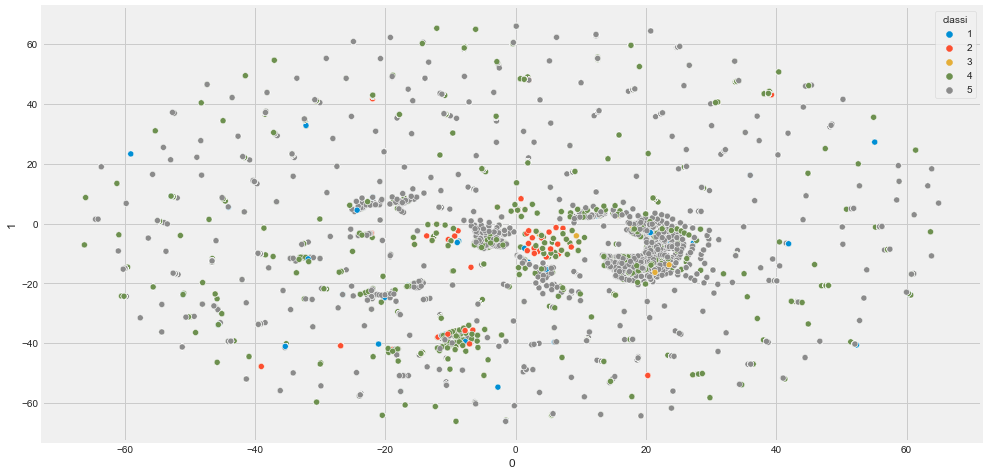

In [109]:
'''1 = Influenza | 2 = other respiratory virus” | 3 = another agent”
4 = “SRAG not specified” |5 =  COVID.'''
#sne2 = pd.DataFrame(sne).assign(classi=y_train.values)
#plt.figure(figsize=(15,8))
#sns.scatterplot(data=sne2, x=0, y=1, hue='classi');

In [6]:
# Replacing the NAs with 9
df_model = df_model.fillna('9')

# Assign as categorical
df_model[num_col] = df_model[num_col].astype('int')
df_model[col_types] = df_model[col_types].astype('category')

In [7]:
df_model.to_csv('to_model.csv', index=False)

 Running KNearest Neighbors only on Symptoms to see if it would help to replace the symptoms by a classification

In [12]:
#knn = KNeighborsClassifier(n_neighbors=5)
#X_knn = X_train[['CS_SEXO', 'NOSOCOMIAL', 'FEBRE', 'TOSSE', 'GARGANTA', 'DISPNEIA', 'DESC_RESP',
#       'SATURACAO', 'DIARREIA', 'VOMITO', 'OUTRO_SIN', 'OUTRO_DES', 'PUERPERA','FATOR_RISC', 'CARDIOPATI', 'HEMATOLOGI', 'SIND_DOWN', 'HEPATICA',
#       'ASMA', 'DIABETES', 'NEUROLOGIC', 'PNEUMOPATI', 'IMUNODEPRE', 'RENAL', 'OBESIDADE', 'OUT_MORBI', 'MORB_DESC', 'VACINA', 'UTI', 'SUPORT_VEN',
#       'HISTO_VGM', 'DOR_ABD', 'FADIGA', 'PERD_OLFT', 'PERD_PALA']].copy()

#X_knn['CS_SEXO'] = X_knn.CS_SEXO.cat.codes
#X_knn['MORB_DESC'] = X_knn.MORB_DESC.cat.codes
#X_knn['OUTRO_DES'] = X_knn.OUTRO_DES.cat.codes

# Fit
#knn.fit(X_knn, y_train)

KNeighborsClassifier()

In [ ]:
#performance = pd.DataFrame({'y_true': y_train.head(1000),
#                            'knn_pred': knn.predict(X_knn.head(1000))})

#confusion_matrix(performance.y_true, performance.knn_pred)

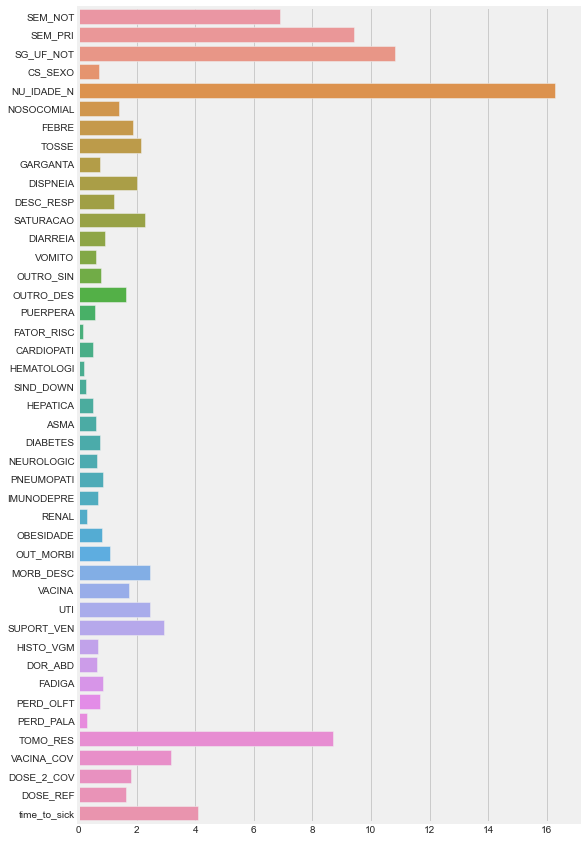

In [125]:
plt.figure(figsize=(8,15))
sns.barplot(y= test.columns, x=model.feature_importances_.sort_values);

In [76]:
drop_cols = str.split('ID, CLASSI_FIN, SIND_DOWN, FATOR_RISC, CARDIOPATI, HEPATICA, HEMATOLOGI, RENAL, PERD_OLFT, '
                      'PERD_PALA, HISTO_VGM, NEUROLOGIC, IMUNODEPRE, CS_SEXO, PUERPERA, DIABETES, PNEUMOPATI, OUT_MORBI', sep=', ')
# X and y
X = df_model.drop(drop_cols, axis=1)
y= df_model.CLASSI_FIN

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, stratify=y, random_state=12)

print(f'Train shapes: {X_train.shape} | {y_train.shape}')
print(f'Test shapes: {X_test.shape} | {y_test.shape}')

Train shapes: (780387, 34) | (780387,)
Test shapes: (520258, 34) | (520258,)


In [77]:
# Find categorical features indices for training
cat_features = X.select_dtypes(include=['object', 'category']).columns.values
#cat_features
# Creating a Pool for training and validation sets
train_pool = Pool(data=X_train, label=y_train, cat_features=cat_features)
test_pool = Pool( data=X_test, label=y_test, cat_features=cat_features)

In [80]:
# Fit
model = CatBoostClassifier(iterations=500, learning_rate=0.34)
model.fit(train_pool, eval_set= test_pool, early_stopping_rounds=20, use_best_model=True, verbose=50)

0:	learn: 0.9988125	test: 0.9993169	best: 0.9993169 (0)	total: 23.9s	remaining: 3h 18m 23s
50:	learn: 0.5224599	test: 0.5251928	best: 0.5251928 (50)	total: 13m 19s	remaining: 1h 57m 16s
100:	learn: 0.5094184	test: 0.5139551	best: 0.5139551 (100)	total: 26m 17s	remaining: 1h 43m 52s
150:	learn: 0.5028090	test: 0.5091091	best: 0.5091091 (150)	total: 38m 57s	remaining: 1h 30m 3s
200:	learn: 0.4978464	test: 0.5058563	best: 0.5058563 (200)	total: 51m 26s	remaining: 1h 16m 31s
250:	learn: 0.4941641	test: 0.5038954	best: 0.5038954 (250)	total: 1h 3m 40s	remaining: 1h 3m 9s
300:	learn: 0.4914553	test: 0.5027252	best: 0.5027252 (300)	total: 1h 15m 47s	remaining: 50m 6s
350:	learn: 0.4891703	test: 0.5018316	best: 0.5018316 (350)	total: 1h 27m 37s	remaining: 37m 11s
400:	learn: 0.4870208	test: 0.5011398	best: 0.5011398 (400)	total: 1h 39m 55s	remaining: 24m 40s
450:	learn: 0.4846125	test: 0.5003749	best: 0.5003749 (450)	total: 1h 52m 6s	remaining: 12m 10s
499:	learn: 0.4825026	test: 0.4998473	bes

In [81]:
# Predict
preds = model.predict(X_test)
accuracy_score(y_test, preds)

0.7907615067908614

In [82]:
confusion_matrix(y_test, preds)

array([[  1279,     89,      3,   3382,   1497],
       [    20,   3071,      2,   8712,    770],
       [    15,     24,    140,   1324,    871],
       [   633,   1965,     49,  90261,  59207],
       [   189,    399,     27,  29680, 316649]], dtype=int64)

### Model Explanation

In [9]:
from_file = CatBoostClassifier()
m = from_file.load_model('model.salvo')

In [104]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

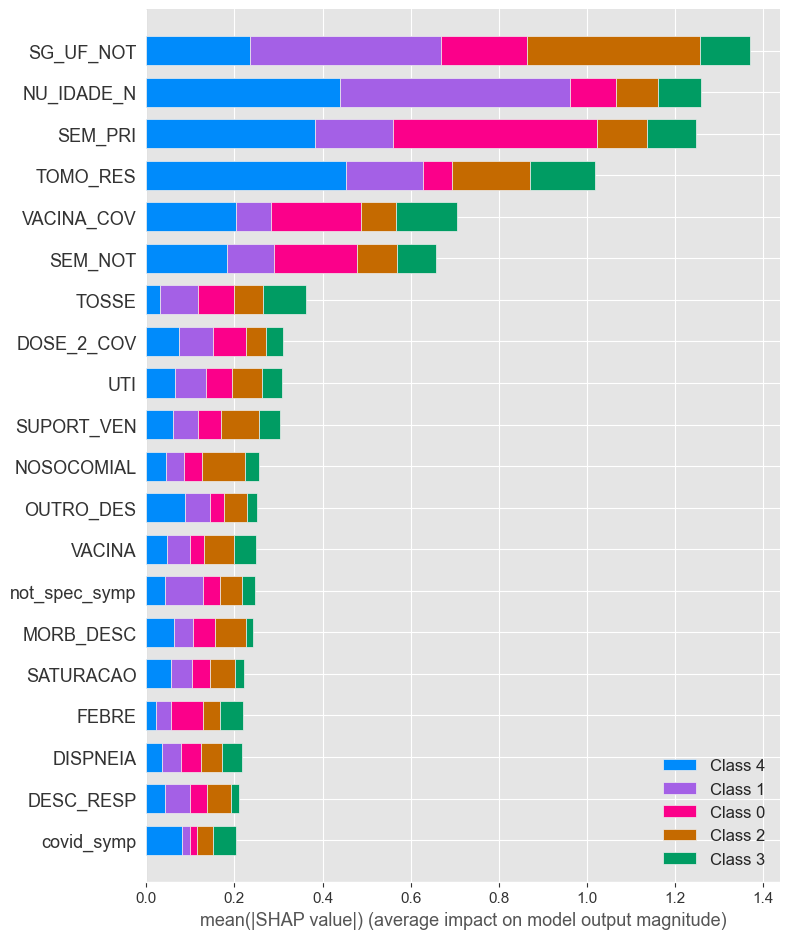

In [106]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X)

# Predictions for Competition

In [83]:
# Load test dataset
file_path = 'C:/Users/1770858/Desktop/ml-olympiad-ensure-healthy-lives/test.csv'
df_test = pd.read_csv(file_path)

Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.


In [84]:
# Select columns to keep
cols_to_keep = ['SEM_NOT', 'SEM_PRI', 'SG_UF_NOT', 'CS_SEXO', 'NU_IDADE_N', 'TP_IDADE', 'NOSOCOMIAL', 'FEBRE', 'TOSSE', 'GARGANTA', 'TP_ANTIVIR',
       'DISPNEIA', 'DESC_RESP', 'SATURACAO', 'DIARREIA', 'VOMITO', 'OUTRO_SIN', 'OUTRO_DES', 'PUERPERA', 'FATOR_RISC', 'CARDIOPATI', 'HEMATOLOGI',
       'SIND_DOWN', 'HEPATICA', 'ASMA', 'DIABETES', 'NEUROLOGIC', 'PNEUMOPATI', 'IMUNODEPRE', 'RENAL', 'OBESIDADE', 'OUT_MORBI', 'MORB_DESC',
       'VACINA', 'UTI', 'SUPORT_VEN', 'HISTO_VGM','DOR_ABD', 'FADIGA', 'PERD_OLFT', 'PERD_PALA', 'TOMO_RES', 'VACINA_COV','DOSE_2_COV', 'DOSE_REF']

# Slice dataset
test = df_test[cols_to_keep].copy()

# Correcting IDADE
# Tipo 1 = dia, tipo 2 = Mês, 3= Ano
test['NU_IDADE_N'] = np.select( [test.TP_IDADE == 1, test.TP_IDADE == 2, test.TP_IDADE == 3],
                                [round(test.NU_IDADE_N/365), round(test.NU_IDADE_N/12), test.NU_IDADE_N] )
test.drop('TP_IDADE', axis=1, inplace=True)

test['influenza_symp'] = symptoms(test, srag='influenza')
test['other_agent_symp'] = symptoms(test, srag='other_agent')
test['other_virus_symp'] = symptoms(test, srag='other_virus')
test['not_spec_symp'] = symptoms(test, srag='not_specific')
test['covid_symp'] = symptoms(test, srag='covid')

# Olfato e Paladar
test['OLF_PLD'] = np.where(test.PERD_OLFT == 1, np.where(test.PERD_PALA == 1, 1, 0),0)

# Replacing the NAs with 9
test = test.fillna('9')

# Columns to Categories for modeling

num_col = ['NOSOCOMIAL', 'FEBRE', 'TOSSE', 'GARGANTA', 
       'DISPNEIA', 'DESC_RESP', 'SATURACAO', 'DIARREIA', 'VOMITO', 'OUTRO_SIN', 'PUERPERA', 'FATOR_RISC', 'CARDIOPATI', 'HEMATOLOGI',
       'SIND_DOWN', 'HEPATICA', 'ASMA', 'DIABETES', 'NEUROLOGIC', 'PNEUMOPATI', 'IMUNODEPRE', 'RENAL', 'OBESIDADE', 'OUT_MORBI', 'TP_ANTIVIR',
       'VACINA', 'UTI', 'SUPORT_VEN', 'HISTO_VGM','DOR_ABD', 'FADIGA', 'PERD_OLFT', 'PERD_PALA', 'TOMO_RES', 'VACINA_COV','DOSE_2_COV', 'DOSE_REF']

col_types = ['SG_UF_NOT', 'CS_SEXO','NOSOCOMIAL', 'FEBRE', 'TOSSE', 'GARGANTA', 'OUTRO_DES', 'MORB_DESC', 'TP_ANTIVIR',
       'DISPNEIA', 'DESC_RESP', 'SATURACAO', 'DIARREIA', 'VOMITO', 'OUTRO_SIN', 'PUERPERA', 'FATOR_RISC', 'CARDIOPATI', 'HEMATOLOGI',
       'SIND_DOWN', 'HEPATICA', 'ASMA', 'DIABETES', 'NEUROLOGIC', 'PNEUMOPATI', 'IMUNODEPRE', 'RENAL', 'OBESIDADE', 'OUT_MORBI',
       'VACINA', 'UTI', 'SUPORT_VEN', 'HISTO_VGM','DOR_ABD', 'FADIGA', 'PERD_OLFT', 'PERD_PALA', 'TOMO_RES', 'VACINA_COV','DOSE_2_COV', 'DOSE_REF']

# Assign as categorical
test[num_col] = test[num_col].astype('int')
test[col_types] = test[col_types].astype('category')
drop_cols = str.split('SIND_DOWN, FATOR_RISC, CARDIOPATI, HEPATICA, HEMATOLOGI, RENAL, PERD_OLFT, '
                      'PERD_PALA, HISTO_VGM, NEUROLOGIC, IMUNODEPRE, CS_SEXO, PUERPERA, DIABETES, PNEUMOPATI, OUT_MORBI', sep=', ')
test.drop(drop_cols, axis=1, inplace=True)

In [85]:
# Prediction
preds_submission = model.predict(test)

In [86]:
# Submission file
pd.DataFrame({
    'ID': df_test.ID,
    'CLASSI_FIN': preds_submission.flatten()
}).to_csv('submission_grs_v6.csv', index=False)

## Associations between symptoms

In [147]:
df_apriori = X_train.drop(['SG_UF_NOT', 'MORB_DESC', 'TOMO_RES', 'OUTRO_SIN', 'OUTRO_DES', 'NU_IDADE_N', 'time_to_sick', 'TP_ANTIVIR'], axis=1).copy()
df_apriori['CS_SEXO'] = df_apriori.CS_SEXO.factorize()[0]
df_apriori['SUPORT_VEN'] = df_apriori.SUPORT_VEN.replace({'3.0': 0, 3:0, '2.0':1, '1.0':1})
df_apriori.replace({'9':0, '9.0':0, 9:0, '2':0, 2:0, '1':1, '0':0}, inplace=True)

In [148]:
df_apriori

,CS_SEXO,NOSOCOMIAL,FEBRE,TOSSE,GARGANTA,DISPNEIA,DESC_RESP,SATURACAO,DIARREIA,VOMITO,...,UTI,SUPORT_VEN,HISTO_VGM,DOR_ABD,FADIGA,PERD_OLFT,PERD_PALA,VACINA_COV,DOSE_2_COV,DOSE_REF
744318,0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0
486136,0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0,0.0,1.0,1.0,1.0,0.0,0,0
813106,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0,0
999383,0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0,0.0,0.0,1.0,0.0,0.0,0,0
589061,0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,0.0,0.0,1.0,1.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
570406,0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0,0.0,0.0,0.0,0.0,1.0,1,0
309390,1,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0,0.0,0.0,0.0,0.0,1.0,1,0
879570,1,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,...,1.0,1.0,0,0.0,0.0,0.0,0.0,0.0,0,0
704471,0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0,0.0,0.0,0.0,0.0,1.0,0,0


In [149]:
# Add SRAG classification
df_apriori['y_'] = y_train

In [64]:
# Instance
#encoder = TransactionEncoder()

# fit the TransactionEncoder
#encode_arr = encoder.fit(orders_listed['UPC Desc'])

# do the transformation
#orders_1hot = encoder.transform(orders_listed['UPC Desc'])

In [150]:
# Associations for COVID
covid = df_apriori.query('y_ == 5').drop('y_', axis=1)
not_specific = df_apriori.query('y_ == 4').drop('y_', axis=1)
other_agent = df_apriori.query('y_ == 3').drop('y_', axis=1)
other_virus = df_apriori.query('y_ == 2').drop('y_', axis=1)
influenza = df_apriori.query('y_ == 1').drop('y_', axis=1)

In [66]:
#encode_df=pd.DataFrame(covid, columns=covid.columns)
#encode_df

In [ ]:
# Calculating Support
prods_sup=mlxtend.frequent_patterns.apriori(covid,
                                            min_support=0.05,
                                            max_len=5,
                                            use_colnames=True)


sup_covid = prods_sup.sort_values(by='support', ascending=False).head(10).reset_index(drop=True)

In [154]:
rules = association_rules(prods_sup, metric="lift", min_threshold=0.05)

rules = rules.sort_values(by='lift', ascending=False).head(20)

rules.head(20)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
1115,(PERD_OLFT),"(PERD_PALA, FEBRE)",0.089167,0.065208,0.051046,0.572484,8.779387,0.045232,2.186566
1114,"(PERD_PALA, FEBRE)",(PERD_OLFT),0.065208,0.089167,0.051046,0.782828,8.779387,0.045232,4.194070
1113,"(FEBRE, PERD_OLFT)",(PERD_PALA),0.064022,0.090863,0.051046,0.797325,8.775055,0.045229,4.485693
1116,(PERD_PALA),"(FEBRE, PERD_OLFT)",0.090863,0.064022,0.051046,0.561798,8.775055,0.045229,2.135949
1923,"(DISPNEIA, PERD_OLFT)",(PERD_PALA),0.067118,0.090863,0.053385,0.795388,8.753732,0.047286,4.443218
1926,(PERD_PALA),"(DISPNEIA, PERD_OLFT)",0.090863,0.067118,0.053385,0.587532,8.753732,0.047286,2.261706
2277,"(SATURACAO, PERD_OLFT)",(PERD_PALA),0.063512,0.090863,0.050470,0.794659,8.745714,0.044699,4.427453
2280,(PERD_PALA),"(SATURACAO, PERD_OLFT)",0.090863,0.063512,0.050470,0.555455,8.745714,0.044699,2.106622
1927,(PERD_OLFT),"(DISPNEIA, PERD_PALA)",0.089167,0.068468,0.053385,0.598707,8.744323,0.047280,2.321328
1922,"(DISPNEIA, PERD_PALA)",(PERD_OLFT),0.068468,0.089167,0.053385,0.779702,8.744323,0.047280,4.134547


For SRAG *COVID*, the top associated symptoms are: PERD_OLFT, PERD_PALA, FEBRE, DISPNEIA.

In [129]:
# Calculating Support
prods_sup=mlxtend.frequent_patterns.apriori(influenza,
                                            min_support=0.05,
                                            max_len=5,
                                            use_colnames=True)
sup_influenza = prods_sup.sort_values(by='support', ascending=False).head(10).reset_index(drop=True)
# Create association Rules
rules = association_rules(prods_sup, metric="lift", min_threshold=0.05)
# Sort association Rules
rules = rules.sort_values(by='lift', ascending=False).head(20)
# Print
rules.head(20)

C:\Users\1770858\AppData\Roaming\Python\Python38\site-packages\mlxtend\frequent_patterns\fpcommon.py:111: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
1990,"(UTI, DESC_RESP)",(SUPORT_VEN),0.144424,0.090494,0.052102,0.360759,3.986575,0.039033,1.422792
1995,(SUPORT_VEN),"(UTI, DESC_RESP)",0.090494,0.144424,0.052102,0.575758,3.986575,0.039033,2.016715
1798,"(UTI, DISPNEIA)",(SUPORT_VEN),0.171846,0.090494,0.058501,0.340426,3.761874,0.042950,1.378929
1803,(SUPORT_VEN),"(UTI, DISPNEIA)",0.090494,0.171846,0.058501,0.646465,3.761874,0.042950,2.342492
19169,"(DESC_RESP, OUT_MORBI, VACINA_COV)","(SATURACAO, DOSE_2_COV)",0.063071,0.220293,0.052102,0.826087,3.749955,0.038208,4.483318
19172,"(SATURACAO, DOSE_2_COV)","(DESC_RESP, OUT_MORBI, VACINA_COV)",0.220293,0.063071,0.052102,0.236515,3.749955,0.038208,1.227173
9217,"(CARDIOPATI, DOSE_2_COV)","(DIABETES, VACINA_COV)",0.137112,0.103291,0.051188,0.373333,3.614395,0.037026,1.430919
19555,"(DIABETES, VACINA_COV, FATOR_RISC)","(CARDIOPATI, DOSE_2_COV)",0.103291,0.137112,0.051188,0.495575,3.614395,0.037026,1.710639
9220,"(DIABETES, VACINA_COV)","(CARDIOPATI, DOSE_2_COV)",0.103291,0.137112,0.051188,0.495575,3.614395,0.037026,1.710639
19552,"(CARDIOPATI, DOSE_2_COV, FATOR_RISC)","(DIABETES, VACINA_COV)",0.137112,0.103291,0.051188,0.373333,3.614395,0.037026,1.430919


For SRAG *Influenza*, the top associated symptoms are: UTI, SUPORT_VEN, DESC_RESP, FADIGA, DISPNEIA, DIABETES, CARDIOPATI.

In [130]:
# Calculating Support
prods_sup=mlxtend.frequent_patterns.apriori(other_virus,
                                            min_support=0.05,
                                            max_len=5,
                                            use_colnames=True)

sup_other_vir = prods_sup.sort_values(by='support', ascending=False).head(10).reset_index(drop=True)
# Create association Rules
rules = association_rules(prods_sup, metric="lift", min_threshold=0.05)
# Sort association Rules
rules = rules.sort_values(by='lift', ascending=False).head(20)
# Print
rules.head(20)

C:\Users\1770858\AppData\Roaming\Python\Python38\site-packages\mlxtend\frequent_patterns\fpcommon.py:111: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
655,"(DISPNEIA, VACINA_COV)",(DOSE_2_COV),0.066788,0.075420,0.052249,0.782313,10.372715,0.047212,4.247288
658,(DOSE_2_COV),"(DISPNEIA, VACINA_COV)",0.075420,0.066788,0.052249,0.692771,10.372715,0.047212,3.037514
563,(VACINA_COV),"(TOSSE, DOSE_2_COV)",0.099955,0.060427,0.060427,0.604545,10.004545,0.054387,2.375932
558,"(TOSSE, DOSE_2_COV)",(VACINA_COV),0.060427,0.099955,0.060427,1.000000,10.004545,0.054387,inf
654,"(DISPNEIA, DOSE_2_COV)",(VACINA_COV),0.052249,0.099955,0.052249,1.000000,10.004545,0.047026,inf
659,(VACINA_COV),"(DISPNEIA, DOSE_2_COV)",0.099955,0.052249,0.052249,0.522727,10.004545,0.047026,1.985764
130,(DOSE_2_COV),(VACINA_COV),0.075420,0.099955,0.075420,1.000000,10.004545,0.067882,inf
131,(VACINA_COV),(DOSE_2_COV),0.099955,0.075420,0.075420,0.754545,10.004545,0.067882,3.766806
562,(DOSE_2_COV),"(TOSSE, VACINA_COV)",0.075420,0.081781,0.060427,0.801205,9.796954,0.054259,4.618920
559,"(TOSSE, VACINA_COV)",(DOSE_2_COV),0.081781,0.075420,0.060427,0.738889,9.796954,0.054259,3.540944


For SRAG *Other Virus*, the top associated symptoms are: DISPNEIA, VACINA_COV, DOSE_2_COV, TOSSE.

In [131]:
# Calculating Support
prods_sup=mlxtend.frequent_patterns.apriori(other_agent,
                                            min_support=0.05,
                                            max_len=5,
                                            use_colnames=True)
sup_other_agent = prods_sup.sort_values(by='support', ascending=False).head(10).reset_index(drop=True)
# Create association Rules
rules = association_rules(prods_sup, metric="lift", min_threshold=0.05)
# Sort association Rules
rules = rules.sort_values(by='lift', ascending=False).head(20)
# Print
rules.head(20)

C:\Users\1770858\AppData\Roaming\Python\Python38\site-packages\mlxtend\frequent_patterns\fpcommon.py:111: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
7442,"(UTI, DOSE_2_COV)","(SUPORT_VEN, VACINA_COV)",0.079518,0.084337,0.053012,0.666667,7.904762,0.046306,2.746988
7447,"(SUPORT_VEN, VACINA_COV)","(UTI, DOSE_2_COV)",0.084337,0.079518,0.053012,0.628571,7.904762,0.046306,2.478221
7444,"(UTI, VACINA_COV)","(SUPORT_VEN, DOSE_2_COV)",0.108434,0.067470,0.053012,0.488889,7.246032,0.045696,1.824515
7445,"(SUPORT_VEN, DOSE_2_COV)","(UTI, VACINA_COV)",0.067470,0.108434,0.053012,0.785714,7.246032,0.045696,4.160643
13050,"(SUPORT_VEN, VACINA_COV)","(UTI, DESC_RESP, FATOR_RISC)",0.084337,0.113253,0.055422,0.657143,5.802432,0.045870,2.586345
13043,"(UTI, DESC_RESP, FATOR_RISC)","(SUPORT_VEN, VACINA_COV)",0.113253,0.084337,0.055422,0.489362,5.802432,0.045870,1.793173
13015,"(UTI, DESC_RESP, OUT_MORBI)","(SUPORT_VEN, FATOR_RISC)",0.067470,0.149398,0.057831,0.857143,5.737327,0.047751,5.954217
13018,"(SUPORT_VEN, FATOR_RISC)","(UTI, DESC_RESP, OUT_MORBI)",0.149398,0.067470,0.057831,0.387097,5.737327,0.047751,1.521497
13013,"(UTI, DESC_RESP, FATOR_RISC)","(SUPORT_VEN, OUT_MORBI)",0.113253,0.091566,0.057831,0.510638,5.576708,0.047461,1.856365
13020,"(SUPORT_VEN, OUT_MORBI)","(UTI, DESC_RESP, FATOR_RISC)",0.091566,0.113253,0.057831,0.631579,5.576708,0.047461,2.406885


For SRAG *Other Agent*, the top associated symptoms are: UTI, SUPORT_VEN, DOSE_2_COV, DESC_RESP.

In [132]:
# Calculating Support
prods_sup=mlxtend.frequent_patterns.apriori(not_specific,
                                            min_support=0.05,
                                            max_len=5,
                                            use_colnames=True)
sup_not_spec = prods_sup.sort_values(by='support', ascending=False).head(10).reset_index(drop=True)
# Create association Rules
rules = association_rules(prods_sup, metric="lift", min_threshold=0.05)
# Sort association Rules
rules = rules.sort_values(by='lift', ascending=False).head(20)
# Print
rules.head(20)

C:\Users\1770858\AppData\Roaming\Python\Python38\site-packages\mlxtend\frequent_patterns\fpcommon.py:111: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
8472,"(SATURACAO, DOSE_2_COV, FATOR_RISC)","(CARDIOPATI, VACINA_COV)",0.134928,0.132975,0.072402,0.536599,4.035327,0.054460,1.871003
8489,"(CARDIOPATI, VACINA_COV)","(SATURACAO, DOSE_2_COV, FATOR_RISC)",0.132975,0.134928,0.072402,0.544479,4.035327,0.054460,1.899082
8234,"(DISPNEIA, DOSE_2_COV, FATOR_RISC)","(CARDIOPATI, VACINA_COV)",0.149386,0.132975,0.079763,0.533937,4.015306,0.059898,1.860315
8247,"(CARDIOPATI, VACINA_COV)","(DISPNEIA, DOSE_2_COV, FATOR_RISC)",0.132975,0.149386,0.079763,0.599831,4.015306,0.059898,2.125635
8442,"(DESC_RESP, DOSE_2_COV, FATOR_RISC)","(CARDIOPATI, VACINA_COV)",0.114574,0.132975,0.060949,0.531957,4.000417,0.045713,1.852446
8459,"(CARDIOPATI, VACINA_COV)","(DESC_RESP, DOSE_2_COV, FATOR_RISC)",0.132975,0.114574,0.060949,0.458345,4.000417,0.045713,1.634668
8456,"(DOSE_2_COV, FATOR_RISC)","(CARDIOPATI, DESC_RESP, VACINA_COV)",0.209621,0.073942,0.060949,0.290756,3.932220,0.045449,1.305697
8445,"(CARDIOPATI, DESC_RESP, VACINA_COV)","(DOSE_2_COV, FATOR_RISC)",0.073942,0.209621,0.060949,0.824276,3.932220,0.045449,4.497850
8473,"(SATURACAO, VACINA_COV, FATOR_RISC)","(CARDIOPATI, DOSE_2_COV)",0.168125,0.109692,0.072402,0.430646,3.925936,0.053960,1.563714
8488,"(CARDIOPATI, DOSE_2_COV)","(SATURACAO, VACINA_COV, FATOR_RISC)",0.109692,0.168125,0.072402,0.660048,3.925936,0.053960,2.447036


For SRAG *Not Specific*, the top associated symptoms are: SATURACAO, FATOR_RISC, CARDIOPATI, VACINA_COV, DOSE_2_COV.

In [133]:
pd.concat([sup_influenza, sup_covid, sup_other_vir, sup_other_agent, sup_not_spec], axis=1)

,support,itemsets,support,itemsets,support,itemsets,support,itemsets,support,itemsets
0,0.796161,(TOSSE),0.694841,(DISPNEIA),0.860064,(TOSSE),0.607229,(TOSSE),0.636487,(TOSSE)
1,0.624314,(FEBRE),0.675213,(TOSSE),0.637438,(DESC_RESP),0.585542,(FATOR_RISC),0.634308,(DISPNEIA)
2,0.566728,(DISPNEIA),0.645985,(SATURACAO),0.631531,(DISPNEIA),0.575904,(DISPNEIA),0.535018,(FATOR_RISC)
3,0.544790,(VACINA_COV),0.586376,(FATOR_RISC),0.623353,(FEBRE),0.515663,(SATURACAO),0.534342,(SATURACAO)
4,0.538391,"(TOSSE, FEBRE)",0.546115,(CS_SEXO),0.558837,"(DESC_RESP, TOSSE)",0.510843,(CS_SEXO),0.516016,(DESC_RESP)
5,0.522852,(FATOR_RISC),0.543464,(DESC_RESP),0.555202,"(DISPNEIA, TOSSE)",0.503614,(DESC_RESP),0.513876,(CS_SEXO)
6,0.476234,(DESC_RESP),0.531180,"(SATURACAO, DISPNEIA)",0.547933,"(TOSSE, FEBRE)",0.448193,(FEBRE),0.455744,(FEBRE)
7,0.463437,(SATURACAO),0.529912,(FEBRE),0.544298,(SATURACAO),0.395181,"(DISPNEIA, TOSSE)",0.435803,"(DISPNEIA, TOSSE)"
8,0.460695,"(DISPNEIA, TOSSE)",0.499531,"(DISPNEIA, TOSSE)",0.543389,(CS_SEXO),0.390361,(VACINA_COV),0.432236,"(SATURACAO, DISPNEIA)"
9,0.455210,"(DOSE_2_COV, VACINA_COV)",0.461328,"(DESC_RESP, DISPNEIA)",0.480691,"(DESC_RESP, DISPNEIA)",0.380723,"(SATURACAO, DISPNEIA)",0.419505,"(DESC_RESP, DISPNEIA)"


In [71]:
def symptoms(dtf, srag):
    "Input a dataset with the symptoms and the respiratory virus to be checked and the functions will calculate the percentage of the symptoms are associated with each disease"
    if srag == 'influenza':
        # columns associated with the virus "influenza"
        cols_d = ['UTI', 'SUPORT_VEN', 'DESC_RESP', 'FADIGA', 'DISPNEIA', 'DIABETES', 'CARDIOPATI']
        # slice the dataset
        dtf2 = dtf[cols_d].copy()
        #For SRAG Not Specific, the top associated symptoms are: SATURACAO, FATOR_RISC, CARDIOPATI, VACINA_COV.
        symps = (dtf2 == 1).sum(axis=1)/7

    # columns associated with the virus "other_virus"
    elif srag == 'other_virus':
        cols_d = ['DISPNEIA', 'VACINA_COV', 'DOSE_2_COV', 'TOSSE']
        # slice the dataset
        dtf2 = dtf[cols_d].copy()
        #For SRAG Not Specific, the top associated symptoms are: SATURACAO, FATOR_RISC, CARDIOPATI, VACINA_COV.
        symps = (dtf2 == 1).sum(axis=1)/4

    # columns associated with the virus "other_agent"
    elif srag == 'other_agent':
        cols_d = ['UTI', 'SUPORT_VEN', 'DOSE_2_COV', 'DESC_RESP']
        # slice the dataset
        dtf2 = dtf[cols_d].copy()
        #For SRAG Not Specific, the top associated symptoms are: SATURACAO, FATOR_RISC, CARDIOPATI, VACINA_COV.
        symps = (dtf2 == 1).sum(axis=1)/4

    # columns associated with the virus "Not Specific"
    elif srag == 'not_specific':
        cols_d = ['SATURACAO', 'FATOR_RISC', 'CARDIOPATI', 'VACINA_COV', 'DOSE_2_COV']
        # slice the dataset
        dtf2 = dtf[cols_d].copy()
        #For SRAG Not Specific, the top associated symptoms are: SATURACAO, FATOR_RISC, CARDIOPATI, VACINA_COV.
        symps = (dtf2 == 1).sum(axis=1)/5

    # columns associated with the virus "COVID"
    elif srag == 'covid':
        cols_d = ['PERD_OLFT', 'PERD_PALA', 'FEBRE', 'DISPNEIA']
        # slice the dataset
        dtf2 = dtf[cols_d].copy()
        #For SRAG Not Specific, the top associated symptoms are: SATURACAO, FATOR_RISC, CARDIOPATI, VACINA_COV.
        symps = (dtf2 == 1).sum(axis=1)/4

    return symps

In [109]:
df_apriori['influenza_symp'] = symptoms(df_apriori, srag='influenza')
df_apriori['other_agent_symp'] = symptoms(df_apriori, srag='other_agent')
df_apriori['other_virus_symp'] = symptoms(df_apriori, srag='other_virus')
df_apriori['not_spec_symp'] = symptoms(df_apriori, srag='not_specific')
df_apriori['covid_symp'] = symptoms(df_apriori, srag='covid')

In [135]:
df_apriori.query('y_ == 2')

,CS_SEXO,NOSOCOMIAL,FEBRE,TOSSE,GARGANTA,DISPNEIA,DESC_RESP,SATURACAO,DIARREIA,VOMITO,...,PERD_PALA,VACINA_COV,DOSE_2_COV,DOSE_REF,y_,influenza_symp,other_agent_symp,other_virus_symp,not_spec_symp,covid_symp
1271089,0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0,0,2,0.285714,0.25,0.50,0.2,0.50
1264232,1,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0,0,2,0.428571,0.50,0.50,0.2,0.25
1278071,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0,0,2,0.285714,0.25,0.25,0.0,0.25
1282299,1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0,0,2,0.142857,0.25,0.25,0.2,0.00
1271776,1,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0,0,2,0.142857,0.00,0.50,0.2,0.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1275839,1,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,0,2,0.142857,0.00,0.50,0.0,0.50
1282642,1,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0,0,2,0.428571,0.50,0.50,0.2,0.25
1280965,1,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0,0,2,0.285714,0.50,0.00,0.4,0.25
1275318,1,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0,0,2,0.428571,0.50,0.50,0.2,0.25


# Feature Selection

In [179]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

XX = X.drop(['time_to_sick', 'NU_IDADE_N'], axis=1).copy()

XX['SG_UF_NOT'] = XX.SG_UF_NOT.cat.codes
XX['OUTRO_DES'] = XX.OUTRO_DES.cat.codes
XX['MORB_DESC'] = XX.MORB_DESC.cat.codes
# Instance of SelectKBest
fsel = SelectKBest(score_func=chi2, k=20)

# Fit
fsel.fit(XX, y)

# Show a dataframe of the results
(
    pd.DataFrame({
        'variable': XX.columns,
        'chi2_stat': fsel.scores_,
        'p_value': fsel.pvalues_})
    .sort_values(by='p_value', ascending=False)
)

,variable,chi2_stat,p_value
28,other_agent_symp,7.284256e+02,2.437442e-156
6,GARGANTA,7.469664e+02,2.353671e-160
29,other_virus_symp,9.035257e+02,2.869152e-194
13,OUTRO_SIN,1.137069e+03,6.985317e-245
11,DIARREIA,1.403901e+03,9.857717e-303
0,SEM_NOT,4.805140e+05,0.000000e+00
20,SUPORT_VEN,2.422383e+04,0.000000e+00
21,DOR_ABD,1.581335e+03,0.000000e+00
22,FADIGA,3.071832e+03,0.000000e+00
23,TOMO_RES,1.775052e+05,0.000000e+00


### Cramers'V

In [218]:
def cramers_v(x, y):
    import scipy.stats as scs
    # Creating a contingency table
    cont_table = pd.crosstab(index= df[x], columns= y)

    # Chi-square value
    X2 = scs.chi2_contingency(cont_table)
    chi_stat = X2[0]
    # Size of the sample
    N = len(df)

    # Minimum between Number of categories in rows-1, # categs columns-1
    minimum_dimension = (min(cont_table.shape)-1)

    # Calculate Cramer's V
    result = np.sqrt((chi_stat/N) / minimum_dimension)
    #return
    return result

In [ ]:
results = {}
for var in X.select_dtypes(include='category').columns:
    r = cramers_v(var, y)
    results[var] = r

In [233]:
pd.DataFrame([results], index=['V']).T

,V
SG_UF_NOT,0.093685
NOSOCOMIAL,0.015611
FEBRE,0.055525
TOSSE,0.050471
GARGANTA,0.059912
TP_ANTIVIR,0.031399
DISPNEIA,0.049690
DESC_RESP,0.034409
SATURACAO,0.072926
DIARREIA,0.045116


## Voting Classifier

In [110]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline

In [122]:
# Copy
dfv = df_model.copy()

dfv['OUTRO_DES'] = dfv.OUTRO_DES.cat.codes
dfv['SG_UF_NOT'] = dfv.SG_UF_NOT.cat.codes
dfv['MORB_DESC'] = dfv.MORB_DESC.cat.codes
to_num = {k:'int' for k in cat_features}

dfv = dfv.astype(to_num)

In [141]:
drop_cols = str.split('ID, CLASSI_FIN, SIND_DOWN, FATOR_RISC, CARDIOPATI, HEPATICA, HEMATOLOGI, RENAL, PERD_OLFT, '
                      'PERD_PALA, HISTO_VGM, NEUROLOGIC, IMUNODEPRE, CS_SEXO, PUERPERA, DIABETES, PNEUMOPATI, OUT_MORBI', sep=', ')
# X and y
X = dfv.drop(drop_cols, axis=1)
y= dfv.CLASSI_FIN

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, stratify=y, random_state=12)

print(f'Train shapes: {X_train.shape} | {y_train.shape}')
print(f'Test shapes: {X_test.shape} | {y_test.shape}')

Train shapes: (845419, 34) | (845419,)
Test shapes: (455226, 34) | (455226,)


In [142]:
# Instance of the algos
rf = RandomForestClassifier(n_estimators=500)
gb = GradientBoostingClassifier(n_estimators=200, learning_rate=0.5)
logit = LogisticRegressionCV(max_iter=1000)

voting = VotingClassifier(
    [('logit', logit),
     ('XGB', gb),
     ('RandomForest', rf)]
)

In [143]:
# Fit the model
voting.fit(X_train, y_train)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

VotingClassifier(estimators=[('logit', LogisticRegressionCV(max_iter=1000)),
                             ('XGB',
                              GradientBoostingClassifier(learning_rate=0.5,
                                                         n_estimators=200)),
                             ('RandomForest',
                              RandomForestClassifier(n_estimators=500))])

In [144]:
voting.score(X_test, y_test)

0.7769305795363183

In [145]:
# Select columns to keep
cols_to_keep = ['SEM_NOT', 'SEM_PRI', 'SG_UF_NOT', 'CS_SEXO', 'NU_IDADE_N', 'TP_IDADE', 'NOSOCOMIAL', 'FEBRE', 'TOSSE', 'GARGANTA', 'TP_ANTIVIR',
       'DISPNEIA', 'DESC_RESP', 'SATURACAO', 'DIARREIA', 'VOMITO', 'OUTRO_SIN', 'OUTRO_DES', 'PUERPERA', 'FATOR_RISC', 'CARDIOPATI', 'HEMATOLOGI',
       'SIND_DOWN', 'HEPATICA', 'ASMA', 'DIABETES', 'NEUROLOGIC', 'PNEUMOPATI', 'IMUNODEPRE', 'RENAL', 'OBESIDADE', 'OUT_MORBI', 'MORB_DESC',
       'VACINA', 'UTI', 'SUPORT_VEN', 'HISTO_VGM','DOR_ABD', 'FADIGA', 'PERD_OLFT', 'PERD_PALA', 'TOMO_RES', 'VACINA_COV','DOSE_2_COV', 'DOSE_REF']

# Slice dataset
test = df_test[cols_to_keep].copy()

# Correcting IDADE
# Tipo 1 = dia, tipo 2 = Mês, 3= Ano
test['NU_IDADE_N'] = np.select( [test.TP_IDADE == 1, test.TP_IDADE == 2, test.TP_IDADE == 3],
                                [round(test.NU_IDADE_N/365), round(test.NU_IDADE_N/12), test.NU_IDADE_N] )
test.drop('TP_IDADE', axis=1, inplace=True)

test['influenza_symp'] = symptoms(test, srag='influenza')
test['other_agent_symp'] = symptoms(test, srag='other_agent')
test['other_virus_symp'] = symptoms(test, srag='other_virus')
test['not_spec_symp'] = symptoms(test, srag='not_specific')
test['covid_symp'] = symptoms(test, srag='covid')

# Olfato e Paladar
test['OLF_PLD'] = np.where(test.PERD_OLFT == 1, np.where(test.PERD_PALA == 1, 1, 0),0)

# Replacing the NAs with 9
test = test.fillna('9')

# Columns to Categories for modeling

num_col = ['NOSOCOMIAL', 'FEBRE', 'TOSSE', 'GARGANTA',
       'DISPNEIA', 'DESC_RESP', 'SATURACAO', 'DIARREIA', 'VOMITO', 'OUTRO_SIN', 'PUERPERA', 'FATOR_RISC', 'CARDIOPATI', 'HEMATOLOGI',
       'SIND_DOWN', 'HEPATICA', 'ASMA', 'DIABETES', 'NEUROLOGIC', 'PNEUMOPATI', 'IMUNODEPRE', 'RENAL', 'OBESIDADE', 'OUT_MORBI', 'TP_ANTIVIR',
       'VACINA', 'UTI', 'SUPORT_VEN', 'HISTO_VGM','DOR_ABD', 'FADIGA', 'PERD_OLFT', 'PERD_PALA', 'TOMO_RES', 'VACINA_COV','DOSE_2_COV', 'DOSE_REF']

col_types = ['SG_UF_NOT', 'NOSOCOMIAL', 'FEBRE', 'TOSSE', 'GARGANTA', 'OUTRO_DES', 'MORB_DESC', 'TP_ANTIVIR',
       'DISPNEIA', 'DESC_RESP', 'SATURACAO', 'DIARREIA', 'VOMITO', 'OUTRO_SIN', 'PUERPERA', 'FATOR_RISC', 'CARDIOPATI', 'HEMATOLOGI',
       'SIND_DOWN', 'HEPATICA', 'ASMA', 'DIABETES', 'NEUROLOGIC', 'PNEUMOPATI', 'IMUNODEPRE', 'RENAL', 'OBESIDADE', 'OUT_MORBI',
       'VACINA', 'UTI', 'SUPORT_VEN', 'HISTO_VGM','DOR_ABD', 'FADIGA', 'PERD_OLFT', 'PERD_PALA', 'TOMO_RES', 'VACINA_COV','DOSE_2_COV', 'DOSE_REF']

# Assign as categorical
test[num_col] = test[num_col].astype('int')
test[col_types] = test[col_types].astype('category')
test['OUTRO_DES'] = test.OUTRO_DES.cat.codes
test['SG_UF_NOT'] = test.SG_UF_NOT.cat.codes
test['MORB_DESC'] = test.MORB_DESC.cat.codes
test[col_types] = test[col_types].astype('int')
drop_cols = str.split('SIND_DOWN, FATOR_RISC, CARDIOPATI, HEPATICA, HEMATOLOGI, RENAL, PERD_OLFT, '
                      'PERD_PALA, HISTO_VGM, NEUROLOGIC, IMUNODEPRE, CS_SEXO, PUERPERA, DIABETES, PNEUMOPATI, OUT_MORBI', sep=', ')
test.drop(drop_cols, axis=1, inplace=True)

In [146]:
# Prediction
preds_submission = voting.predict(test)

# Submission file
pd.DataFrame({
    'ID': df_test.ID,
    'CLASSI_FIN': preds_submission.flatten()
}).to_csv('submission_grs_v7.csv', index=False)